In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import MetaTrader5 as mt5
import datetime as dt
import ta
import pytz
from statsmodels.regression.rolling import RollingOLS
import numpy as np
from scipy.optimize import minimize
import pickle
from sklearn.cluster import KMeans
timezone = pytz.timezone("Etc/UTC")
timezone
today = dt.datetime.now()

c:\Users\camps pro\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def padrao(df):
    df.rename(columns={'time':'Date', 'open':'Open', 'high':'High','low':'Low','close':'Close'}, inplace=True)
    df.drop(['tick_volume','spread','real_volume'], axis=1, inplace=True)
    df.set_index('Date', inplace=True)
    return df

def retorno(df):
    df['Retorno'] = df['Close'].pct_change()
    
    df.dropna(inplace=True)
    return df

In [3]:
def var(df):
    

    #alvo 3
    df["Retorno3"] = df["Close"].pct_change(3)
    df["Alvo3"] = df["Retorno3"].shift(-3)*100
    df["Alvo3_cat"] = np.where(df["Alvo3"] > 0 , 1, 0)

    


    df['RSL5'] = (df['Close']/df['Close'].rolling(5).mean())-1
    df['RSL5q'] = pd.qcut(df['RSL5'], q=7, labels=False)
    df['RSL20'] = (df['Close']/df['Close'].rolling(20).mean())-1

    df['delta'] = df['Close'].diff()
    df['gain'] = np.where(df['delta']>=0, df['delta'], 0)
    df['loss'] = np.where(df['delta']<0, abs(df['delta']), 0)
    avg_gain = df['gain'].rolling(window=5).mean()
    avg_loss = df['loss'].rolling(window=5).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))
    df['rsi_cat'] = pd.qcut(df['rsi'], 7,labels=False)

    df['filtro'] = np.where(df["RSL5"] < df["RSL20"], 1, -1) 
    df['media_movel'] = df['Close'].rolling(200).mean()
    df['media_movel2'] = df['Close'].rolling(5).mean()
    h = df['media_movel2'] / df['media_movel']
    l = 3 
    df['tan200'] = h/l
    df['ang200'] = np.degrees(df['tan200'])
    df['ang_cat'] = pd.qcut(df['ang200'], q=5, labels=False)

    df['sinal'] = np.where((df['filtro']==-1)& ((df['ang_cat'] ==0) | df['ang_cat'] ==2), -1,
                            np.where((df['filtro']==1)& ((df['ang_cat'] ==5) | df['ang_cat'] ==3), 1, 0)) 

    df['rsi_sinal'] = np.where(df['rsi'] < 30, 1,
                          np.where(df['rsi'] > 70, -1, 0))


    df['rsi_cat_sinal'] = np.where((df['rsi_sinal'] == 1) & ((df['rsi_cat'] == 4)| (df['rsi_cat'] == 6)| (df['rsi_cat'] == 1)),1,
                            np.where((df['rsi_sinal'] == -1) & ((df['rsi_cat'] == 2)| (df['rsi_cat'] == 5)), -1, 0))


    df['desvio_padrao'] = df["Retorno"].rolling(window=15).std()
    df['media'] = df["Retorno"].rolling(window=15).mean()
    df['ajuste_media'] = df["Retorno"] - df['media']
    df['max_diff'] = df['ajuste_media'].rolling(window=15).max()
    df['min_diff'] = df['ajuste_media'].rolling(window=15).min()
    df['R/S'] = (df['max_diff'] - df['min_diff'])/df['desvio_padrao']
    df['hurst'] = (np.log2(df['R/S'].values))/np.log2(15)

    df['hurst_sinal'] = np.where(df['hurst'] > 0.5, 1, np.where(df['hurst'] < 0.45, -1, 0))

    df['std15'] = df['Close'].rolling(15).std()
    df['MA'] = df['Close'].rolling(5).mean()

    df["zscore"] = ((df["Close"]-df['Close'].rolling(5).mean())/df['Close'].rolling(10).std())
    std = (df['zscore'].std())*1.2
    df['zscore_sinal'] = np.where(df['zscore'] > std, -1, np.where(df['zscore'] < -std, 1, 0))


    df['delta'] = df['Close'].diff()
    df['gain'] = np.where(df['delta']>=0, df['delta'], 0)
    df['loss'] = np.where(df['delta']<0, abs(df['delta']), 0)
    avg_gain = df['gain'].rolling(window=5).mean()
    avg_loss = df['loss'].rolling(window=5).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))
    #df['rsi'] = pd.qcut(df['rsi'], 5,labels=False)





    stochasticOscillator = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=15, smooth_window=3)
    df['stochasticOscillator'] = stochasticOscillator.stoch()
    df['stochasticOscillator'] = df['stochasticOscillator']/100
    #df['stochasticOscillator'] = pd.qcut(df['stochasticOscillator'], 5, labels=False)

    df['stochasticOscillator_sinal'] = np.where(df['stochasticOscillator'] <= 0.2, 1, np.where(df['stochasticOscillator'] < 0.8, -1, 0))



    #bandas de bollingerBand
    bollingerBand = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['bb_bollinger_avg'] = bollingerBand.bollinger_mavg()
    df['bb_lband'] = bollingerBand.bollinger_lband()
    df['bb_hband'] = bollingerBand.bollinger_hband()
    df['sinal_bb'] = np.where(df['Close']>df['bb_hband'],-1, np.where(df['Close']<df['bb_lband'],1,0))


    
    h = df['Close'].shift(21) - df['Close']
    l = 21
    df['tan30'] = h/l
    df['ang30'] = np.arctan(df['tan30'])
    std = (df['ang30'].std())
    df['tan30_sinal'] = np.where(df['ang30'] > std, 1, np.where(df['ang30'] < -std, -1, 0))
    df['tan30_cat'] = pd.qcut(df['ang30'], q=4, labels=[1,2,3,4])




    stochRSI = ta.momentum.StochRSIIndicator(close=df['Close'], window=15, smooth1=3, smooth2=3)
    df['stochRSI'] = stochRSI.stochrsi()
    df['stochRSI_cat'] = pd.qcut(df['stochRSI'], 5, labels=False)

    df['stochRSI_sinal'] = np.where((df['tan30_cat'] == 1) & (df['stochRSI_cat'] == 0), 1,
                                np.where((df['tan30_cat'] == 2) & (df['stochRSI_cat'] == 4), -1, 0))



    vol_p1 = 20
    df['Vol'] = np.round(df['Retorno'].rolling(vol_p1).std()*np.sqrt(252), 4)

    df["Date"] = df.index
    df["WeekDay"] = df["Date"].dt.dayofweek #Monday is day 0


    WeeklyVol = df["Vol"]/np.sqrt(52)
    RefPrice = df["Close"]
    df["WeeklyVol"] = df["Vol"]/np.sqrt(52)
    df["RefPrice"] = df["Close"]

    for i in range(1,len(df)):
        if df["WeekDay"][i] == 0:
            df["WeeklyVol"][i] = WeeklyVol[i-1]
            df["RefPrice"][i] = RefPrice[i-1]
        else:
            df["WeeklyVol"][i] = df["WeeklyVol"][i-1]
            df["RefPrice"][i] = df["RefPrice"][i-1]

    df["Supply_Band_1d"] = np.round(df["WeeklyVol"]*df["RefPrice"] + df["RefPrice"], 2)
    df["Demand_Band_1d"] = np.round(df["RefPrice"] - df["WeeklyVol"]*df["RefPrice"], 2)
    df["Supply_Band_2d"] = np.round(2*df["WeeklyVol"]*df["RefPrice"] + df["RefPrice"], 2)
    df["Demand_Band_2d"] = np.round(df["RefPrice"] - 2*df["WeeklyVol"]*df["RefPrice"], 2)


    df['macd_9'] = df['Retorno'].rolling(window=10).mean()
    df['macd_26'] = df['Retorno'].ewm(span=30, adjust=False).mean()
    df['disc_macs'] = (df['macd_9'] - df['macd_26'])-1
    df['disc_macs'] = pd.qcut(df['disc_macs'], 10, labels=False)

    df["dis_vol"] = df["Vol"]/df["WeeklyVol"]
    df["dis_vol_cat"] = pd.qcut(df["dis_vol"], 7, labels=False)

    df['Return20'] = df['Close'].pct_change(20)
    df['sum_returns']=df['Return20'].rolling(5).mean()
    df['return_cost'] = df['Return20']/df['sum_returns']
    df['return_cost_cat'] = pd.qcut(df['return_cost'], 7, labels=False)


    df['MA20'] = df['Close'].rolling(20).mean()
    #df['Return20'] = df['Return20'].shift(-20)
    df['STD_Returns'] = df['Return20'].rolling(20).std()
    df['RSL20'] = (df['Close']/df['MA20'])-1
    df['RSL'] = (df['Close']/df['Close'].rolling(10).mean())-1

    df['delta1'] = df['Close'].diff()
    df['gain1'] = np.where(df['delta1']>=0, df['delta1'], 0)
    df['loss1'] = np.where(df['delta1']<0, abs(df['delta1']), 0)
    avg_gain1 = df['gain1'].rolling(window=20).mean()
    avg_loss1 = df['loss1'].rolling(window=20).mean()
    rs1 = avg_gain1 / avg_loss1
    df['rsi1'] = 100 - (100 / (1 + rs1))




    last_friday_return = 0

    df["FRI_Returns"] = None

    # Iterate through df1
    for idx, row in df.iterrows():
        # Check if the day is Friday (weekday() returns 4 for Friday)
        if idx.weekday() == 4:
            last_friday_return = row["Return20"]
        
        df.at[idx, "FRI_Returns"] = last_friday_return

    # Initialize a variable to store the last Friday STD_Returns
    last_STD_Returns = 0

    # Create a new column for the Friday STD_Returns in df1
    df["FRI_STD_Returns"] = None

    # Iterate through df1
    for idx, row in df.iterrows():
        # Check if the day is Friday (weekday() returns 4 for Friday)
        if idx.weekday() == 4:
            last_STD_Returns = row["STD_Returns"]
        
        df.at[idx, "FRI_STD_Returns"] = last_STD_Returns


    # Initialize a variable to store the last Friday RSL
    last_RSL = 0

    # Create a new column for the Friday RSL in df1
    df["FRI_RSL"] = None

    # Iterate through df1
    for idx, row in df.iterrows():
        # Check if the day is Friday (weekday() returns 4 for Friday)
        if idx.weekday() == 4:
            last_RSL = row["RSL20"]
        
        df.at[idx, "FRI_RSL"] = last_RSL

    last_rsi = 0
    df['FRI_rsi'] = None
    for idx, row in df.iterrows():
        if idx.weekday() == 4:
            last_rsi = row['rsi1']  # Substitua last_friday_rsi por last_rsi

        df.at[idx, "FRI_rsi"] = last_rsi

    df.dropna(axis = 0, inplace = True) 
    #Distância do cosseno
    # Initialize a list to store the results for each row
    COS_DIST = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row
        array1 = row[["FRI_Returns", "FRI_STD_Returns", "FRI_RSL"]].to_numpy()
        array2 = row[["Return20", "STD_Returns", "RSL"]].to_numpy()

        # Dot product of the two arrays
        dot_product = np.dot(array1, array2)

        # Sum of squares of each array and then square root
        sqrt_sum_squares_array1 = np.sqrt(np.sum(np.square(array1)))
        sqrt_sum_squares_array2 = np.sqrt(np.sum(np.square(array2)))

        # Calculate the result for this row and append it to the results list
        row_result = dot_product / (sqrt_sum_squares_array1 + sqrt_sum_squares_array2)
        COS_DIST.append(row_result)

    # Add the results as a new column to df1
    df["COS_DIST"] = COS_DIST
    df['COS_DIST_cat'] = pd.qcut(df['COS_DIST'], 7, labels=False)


    # Iterate over each row in the DataFrame

    COS_DIST2 = []
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row
        array1 = row[["FRI_Returns", "FRI_STD_Returns", "FRI_RSL",'FRI_rsi']].to_numpy()
        array2 = row[["Return20", "STD_Returns", "RSL",'rsi1']].to_numpy()

        # Dot product of the two arrays
        dot_product = np.dot(array1, array2)

        # Sum of squares of each array and then square root
        sqrt_sum_squares_array1 = np.sqrt(np.sum(np.square(array1)))
        sqrt_sum_squares_array2 = np.sqrt(np.sum(np.square(array2)))

        # Calculate the result for this row and append it to the results list
        row_result = dot_product / (sqrt_sum_squares_array1 + sqrt_sum_squares_array2)
        COS_DIST2.append(row_result)

    # Add the results as a new column to df1
    df["COS_DIST2"] = COS_DIST2
    df['COS_DIST2_cat'] = pd.qcut(df['COS_DIST2'], 7, labels=False)





    # Initialize a list to store the Euclidean distances for each row
    euclidean_distances = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row
        array1 = row[["FRI_Returns", "FRI_STD_Returns", "FRI_RSL"]].to_numpy()
        array2 = row[["Return20", "STD_Returns", "RSL"]].to_numpy()

        # Calculate Euclidean distance
        distance = np.linalg.norm(array1 - array2)

        # Append the calculated distance to the list
        euclidean_distances.append(distance)

    # Add the Euclidean distances as a new column to df1
    df["EUC_DIST"] = euclidean_distances
    df['EUC_DIST_cat'] = pd.qcut(df['EUC_DIST'], 7, labels=False)

    euclidean_distances2 = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row
        array1 = row[["FRI_Returns", "FRI_STD_Returns", "FRI_RSL",'FRI_rsi']].to_numpy()
        array2 = row[["Return20", "STD_Returns", "RSL",'rsi1']].to_numpy()

        # Calculate Euclidean distance
        distance = np.linalg.norm(array1 - array2)

        # Append the calculated distance to the list
        euclidean_distances2.append(distance)

    # Add the Euclidean distances as a new column to df1
    df["EUC_DIST2"] = euclidean_distances2
    df['EUC_DIST2_cat'] = pd.qcut(df['EUC_DIST2'], 7, labels=False)


    df['curva_rsl'] = np.where(df['FRI_RSL'] == df['RSL20'], 0, 
                            np.where(df['FRI_RSL'] > df['RSL20'], 1, -1))

    df['curva_std'] = np.where(df['FRI_STD_Returns'] == df['STD_Returns'], 0, 
                            np.where(df['FRI_STD_Returns'] > df['STD_Returns'], 1, -1))


    df['dis_rsl'] = df['RSL20']/df['FRI_RSL']

    df['dis_std'] = df['STD_Returns']/df['FRI_STD_Returns']


    df['dis_euc_sinal'] = np.where(((g['EUC_DIST2_cat']== 0) & (g['EUC_DIST_cat']== 3)), 1,
                                np.where(((df['EUC_DIST_cat']== 5) | (df['EUC_DIST_cat']== 6)) & ((df['EUC_DIST2_cat']== 4) | (df['EUC_DIST2_cat']== 5)), -1, 0))

    df['dis_cos_sinal'] = np.where(((g['COS_DIST_cat']== 2) | (g['COS_DIST_cat']== 6)) & (g['COS_DIST2_cat']== 2), 1,
                                np.where(((df['COS_DIST_cat']== 1) | (df['COS_DIST_cat']== 4)) & ((df['COS_DIST2_cat']== 1) | (df['COS_DIST2_cat']== 0)), -1, 0))

    df['RSL20_cat'] = pd.qcut(df['RSL20'], 7, labels=False)


    df['Price_Lag'] = df['Close'].shift(1)
    df['Price_Lag2'] = df['Close'].shift(2)

    # Adicione a constante ao DataFrame
    df["const"] = 1

    # Ajuste o modelo de regressão com as novas colunas
    rolling_reg = RollingOLS(endog=df["Close"], exog=df[["const", "Price_Lag", "Price_Lag2"]], window=252)
    reg = rolling_reg.fit()

    # Extraia os coeficientes do modelo
    df['beta0'] = reg.params['const']
    df['beta1'] = reg.params['Price_Lag']
    df['beta2'] = reg.params['Price_Lag2']

    # Calcule a regressão
    df['reg'] = df['beta0'] + df['beta1'] * df['Price_Lag'] + df['beta2'] * df['Price_Lag2']
    df['detrend_reg'] = df['Close'] - df['reg']

    df['MM20'] = df['Close'].rolling(20).mean()

    df['index'] = np.arange(len(df))

    df['curva1_a'] = 1
    df['curva1_b'] = 1
    df['curva1_c'] = 1
    df['curva1_d'] = 1

    df['curva2_a'] = 1
    df['curva2_b'] = 2
    df['curva2_c'] = 1
    df['curva2_d'] = 1

    df['curva3_a'] = 1
    df['curva3_b'] = 3
    df['curva3_c'] = 1
    df['curva3_d'] = 1

    df['curva1'] = df['curva1_a'] * np.sin(df['curva1_b'] * df['index'] + df['curva1_c']) + df['curva1_d']
    df['curva2'] = df['curva2_a'] * np.sin(df['curva2_b'] * df['index'] + df['curva2_c']) + df['curva2_d']
    df['curva3'] = df['curva3_a'] * np.sin(df['curva3_b'] * df['index'] + df['curva3_c']) + df['curva3_d']


    df['curva_final'] = df['curva1'] + df['curva2'] + df['curva3']

    df['erro'] = df['detrend_reg'] - df['curva_final']



    # Função para calcular o erro total
    def erro_total(params, df):
        a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3 = params
        
        curva1 = a1 * np.sin(b1 * df['index'] + c1) + d1
        curva2 = a2 * np.sin(b2 * df['index'] + c2) + d2
        curva3 = a3 * np.sin(b3 * df['index'] + c3) + d3
        
        curva_final = curva1 + curva2 + curva3
        erro = df['detrend_reg'] - curva_final
        return np.sum(erro**2)

    # Estimativa inicial dos parâmetros
    initial_guess = [1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1]

    # Minimizar o erro para encontrar os melhores parâmetros
    result = minimize(erro_total, initial_guess, args=(df,), method='Nelder-Mead')

    # Extrair os melhores parâmetros encontrados
    a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3 = result.x
    print("Melhores parâmetros para a Curva 1:", a1, b1, c1, d1)
    print("Melhores parâmetros para a Curva 2:", a2, b2, c2, d2)
    print("Melhores parâmetros para a Curva 3:", a3, b3, c3, d3)

    # Calcular as curvas com os melhores parâmetros
    df['curva1_otimizada'] = a1 * np.sin(b1 * df['index'] + c1) + d1
    df['curva2_otimizada'] = a2 * np.sin(b2 * df['index'] + c2) + d2
    df['curva3_otimizada'] = a3 * np.sin(b3 * df['index'] + c3) + d3

    # Calcular a curva final otimizada
    df['curva_final_otimizada'] = df['curva1_otimizada'] + df['curva2_otimizada'] + df['curva3_otimizada']

    #categorizar as curvas
    df['curva_final_cat'] = pd.qcut(df['curva_final_otimizada'], 15, labels=False)
    df['curva1_cat'] = pd.qcut(df['curva1_otimizada'], 15, labels=False)
    df['curva2_cat'] = pd.qcut(df['curva2_otimizada'], 15, labels=False)
    df['curva3_cat'] = pd.qcut(df['curva3_otimizada'], 15, labels=False)
    
    df.dropna(inplace=True)
    kmeans = KMeans(n_clusters = 20, random_state = 42).fit(df[['curva_final_otimizada','curva1_otimizada','curva2_otimizada','curva3_otimizada','detrend_reg']])
    df['cluster_curvas'] = kmeans.labels_
    #salvar o modelo

    filename = 'kmeans_curvas.sav'
    pickle.dump(kmeans, open(filename, 'wb'))

    
        
    return df


Melhores parâmetros para a Curva 1: 1.5505273509954591 0.8627974364633149 -0.5107090962968175 5.067783992607492
Melhores parâmetros para a Curva 2: 0.4928078998565719 2.601774129153485 4.352681337119602 -2.6978077541755248
Melhores parâmetros para a Curva 3: -0.20773700559657748 4.116048600762351 -0.36911661308756893 -2.223926882032824

In [4]:
ativos = ["XTIUSD"]
ativo = ativos[0]
mt5.initialize()

g = mt5.copy_rates_from(ativo, mt5.TIMEFRAME_D1, today, 4680)
g = pd.DataFrame(g)
g['time'] = pd.to_datetime(g['time'], unit='s')
padrao(g)
retorno(g)
var(g)


C:\Users\camps pro\AppData\Local\Temp\ipykernel_6188\2095710888.py:127: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df["WeekDay"][i] == 0:
C:\Users\camps pro\AppData\Local\Temp\ipykernel_6188\2095710888.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["WeeklyVol"][i] = df["WeeklyVol"][i-1]
C:\Users\camps pro\AppData\Local\Temp\ipykernel_6188\2095710888.py:131: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.

Melhores parâmetros para a Curva 1: 1.5505273509954591 0.8627974364633149 -0.5107090962968175 5.067783992607492
Melhores parâmetros para a Curva 2: 0.4928078998565719 2.601774129153485 4.352681337119602 -2.6978077541755248
Melhores parâmetros para a Curva 3: -0.20773700559657748 4.116048600762351 -0.36911661308756893 -2.223926882032824


C:\Users\camps pro\AppData\Local\Temp\ipykernel_6188\2095710888.py:407: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['curva1_otimizada'] = a1 * np.sin(b1 * df['index'] + c1) + d1
C:\Users\camps pro\AppData\Local\Temp\ipykernel_6188\2095710888.py:408: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['curva2_otimizada'] = a2 * np.sin(b2 * df['index'] + c2) + d2
C:\Users\camps pro\AppData\Local\Temp\ipykernel_6188\2095710888.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

,Open,High,Low,Close,Retorno,Retorno3,Alvo3,Alvo3_cat,RSL5,RSL5q,...,erro,curva1_otimizada,curva2_otimizada,curva3_otimizada,curva_final_otimizada,curva_final_cat,curva1_cat,curva2_cat,curva3_cat,cluster_curvas
Date,,,,,,,,,,,,,,,,,,,,,
2011-10-14,84.13,87.35,83.76,87.33,0.038283,0.027049,1.110729,1,0.023438,6.0,...,-1.030248,6.088365,-3.053081,-2.376506,0.658778,9,10,3,3,9
2011-10-16,87.41,87.66,87.23,87.40,0.000802,0.030053,-1.338673,0,0.019313,5.0,...,-4.706114,4.844739,-2.568592,-2.254879,0.021268,7,6,8,6,18
2011-10-17,87.43,88.16,85.86,86.20,-0.013730,0.024848,0.092807,1,0.002582,3.0,...,-3.593044,3.757104,-2.564218,-2.036581,-0.843695,3,2,8,12,5
2011-10-18,86.24,89.00,85.53,88.30,0.024362,0.011107,-0.736127,0,0.018830,5.0,...,-1.108675,3.586120,-3.056211,-2.403408,-1.873499,0,1,3,2,8
2011-10-19,88.30,89.66,86.00,86.23,-0.023443,-0.013387,1.356836,1,-0.009898,1.0,...,-4.398847,4.451367,-2.216520,-2.209673,0.025175,7,5,13,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-17,85.39,85.57,82.58,82.87,-0.028829,-0.031100,-0.325812,0,-0.025288,0.0,...,-6.503316,6.596417,-2.252206,-2.301071,2.043140,14,14,12,5,17
2024-04-18,82.85,83.40,81.62,82.44,-0.005189,-0.038376,1.698205,1,-0.022991,0.0,...,-4.831342,6.259123,-2.971868,-2.340192,0.947064,10,11,4,4,4
2024-04-19,82.53,86.18,81.69,82.65,0.002547,-0.031407,0.713854,1,-0.013770,1.0,...,-1.995601,5.088642,-2.673232,-2.016190,0.399220,8,7,7,14,18


In [5]:
df = g.copy()
last_curvaf = 0
df['FRI_curva_final'] = None
for idx, row in df.iterrows():
    if idx.weekday() == 4:
        last_curvaf = row['curva_final_otimizada']

    df.at[idx, "FRI_curva_final"] = last_curvaf

last_curva1 = 0
df['FRI_curva1'] = None
for idx, row in df.iterrows():
    if idx.weekday() == 4:
        last_curva1 = row['curva1_otimizada']

    df.at[idx, "FRI_curva1"] = last_curva1

last_curva2 = 0
df['FRI_curva2'] = None
for idx, row in df.iterrows():
    if idx.weekday() == 4:
        last_curva2 = row['curva2_otimizada']

    df.at[idx, "FRI_curva2"] = last_curva2

last_curva3 = 0
df['FRI_curva3'] = None
for idx, row in df.iterrows():
    if idx.weekday() == 4:
        last_curva3 = row['curva3_otimizada']

    df.at[idx, "FRI_curva3"] = last_curva3

last_hurst = 0
df['FRI_hurst'] = None
for idx, row in df.iterrows():
    if idx.weekday() == 4:
        last_hurst = row['hurst']

    df.at[idx, "FRI_hurst"] = last_hurst


df.dropna(axis = 0, inplace = True) 


COS_DIST3 = []
for index, row in df.iterrows():
    # Extract the values for each set of columns for this row
    array1 = row[['FRI_hurst',"FRI_curva1","FRI_curva2","FRI_curva3","FRI_curva_final"]].to_numpy()
    array2 = row[['hurst','curva1_otimizada','curva2_otimizada','curva3_otimizada','curva_final_otimizada']].to_numpy()

    # Dot product of the two arrays
    dot_product = np.dot(array1, array2)

    # Sum of squares of each array and then square root
    sqrt_sum_squares_array1 = np.sqrt(np.sum(np.square(array1)))
    sqrt_sum_squares_array2 = np.sqrt(np.sum(np.square(array2)))

    # Calculate the result for this row and append it to the results list
    row_result = dot_product / (sqrt_sum_squares_array1 + sqrt_sum_squares_array2)
    COS_DIST3.append(row_result)

# Add the results as a new column to df1
df["COS_DIST3"] = COS_DIST3
df['COS_DIST3_cat'] = pd.qcut(df['COS_DIST3'], 5, labels=False)







# Initialize a list to store the Euclidean distances for each row
euclidean_distances = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Extract the values for each set of columns for this row

    array1 = row[['FRI_hurst',"FRI_curva1","FRI_curva2","FRI_curva3","FRI_curva_final"]].to_numpy()
    array2 = row[['hurst','curva1_otimizada','curva2_otimizada','curva3_otimizada','curva_final_otimizada']].to_numpy()

    # Calculate Euclidean distance
    distance = np.linalg.norm(array1 - array2)

    # Append the calculated distance to the list
    euclidean_distances.append(distance)

# Add the Euclidean distances as a new column to df1
df["EUC_DIST3"] = euclidean_distances
df['EUC_DIST3_cat'] = pd.qcut(df['EUC_DIST3'], 5, labels=False)

In [6]:
g['retorno4'] = g['Close'].pct_change(1)*100
g['Retorno4']= g['retorno4'].shift(-1)
g['Retorno4_bin'] = np.where(g['Retorno4'] > 0, 1, 0)

C:\Users\camps pro\AppData\Local\Temp\ipykernel_6188\1867519541.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  g['retorno4'] = g['Close'].pct_change(1)*100
C:\Users\camps pro\AppData\Local\Temp\ipykernel_6188\1867519541.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  g['Retorno4']= g['retorno4'].shift(-1)
C:\Users\camps pro\AppData\Local\Temp\ipykernel_6188\1867519541.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

In [8]:
kmeans = KMeans(n_clusters = 20, random_state = 42).fit(df[[ 
       'COS_DIST3', 'EUC_DIST3',
       'COS_DIST', 'EUC_DIST',
        'COS_DIST2', 'EUC_DIST2'
       ]])
df['cluster_distance'] = kmeans.labels_

c:\Users\camps pro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [9]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import classification_report, accuracy_score

df['lag1'] = df['Retorno'].shift(-1)
alvo = ['lag1']

df['lag1_bin'] = np.where(df['lag1'] > 0, 1, 0)
lista = [
 'curva1_cat','curva2_cat','curva3_cat','curva_final_cat',
 'COS_DIST3',
 'COS_DIST3_cat',
 'EUC_DIST3',
 'EUC_DIST3_cat']

start_train = "2010-01-01"
end_train = "2021-12-31"
df_filtrado = df.dropna()
# Vamos testar o modelo de 2011 à 2020
start_test = "2022-01-01"
end_test = "2024-04-08"

df_filtrado.dropna(inplace=True)

df_train = df_filtrado[start_train : end_train]

df_test = df_filtrado[start_test : end_test]

x_train = df_train[lista]
y_train = df_train[alvo]

x_test = df_test[lista]
y_test = df_test[alvo]


x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

lr_sm = sm.GLM(y_train, x_train).fit()

y_pred_train= lr_sm.predict(x_train)

y_pred_test = lr_sm.predict(x_test)

df_test['y_pred'] = y_pred_test
df_test['pred'] = np.where(df_test['y_pred'] > 0, 1, 0)
print(classification_report(df_test['lag1_bin'], df_test['pred']))
print(accuracy_score(df_test['lag1_bin'], df_test['pred']))
lr_sm.summary()

              precision    recall  f1-score   support

           0       0.52      0.42      0.46       269
           1       0.58      0.68      0.62       315

    accuracy                           0.56       584
   macro avg       0.55      0.55      0.54       584
weighted avg       0.55      0.56      0.55       584

0.5565068493150684


C:\Users\camps pro\AppData\Local\Temp\ipykernel_6188\293084461.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado.dropna(inplace=True)
C:\Users\camps pro\AppData\Local\Temp\ipykernel_6188\293084461.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred'] = y_pred_test
C:\Users\camps pro\AppData\Local\Temp\ipykernel_6188\293084461.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   lag1   No. Observations:                 2715
Model:                            GLM   Df Residuals:                     2706
Model Family:                Gaussian   Df Model:                            8
Link Function:               Identity   Scale:                      0.00080508
Method:                          IRLS   Log-Likelihood:                 5823.7
Date:                Fri, 26 Apr 2024   Deviance:                       2.1785
Time:                        21:08:54   Pearson chi2:                     2.18
No. Iterations:                     3   Pseudo R-squ. (CS):           0.003828
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0324      0.013      2.567      0.010       0.008       0.057
curva1_cat         -0.0006      0.001     -0.821      0.411      -0.002       0.001
curva2_cat         -0.0004      0.000     -1.276      0.202      -0.001       0.000
curva3_cat       8.112e-06      0.000      0.050      0.960      -0.000       0.000
curva_final_cat     0.0008      0.001      0.953      0.341      -0.001       0.002
COS_DIST3          -0.0117      0.005     -2.458      0.014      -0.021      -0.002
COS_DIST3_cat       0.0022      0.001      1.909      0.056   -5.83e-05       0.004
EUC_DIST3           0.0007      0.002      0.396      0.692      -0.003       0.004
EUC_DIST3_cat      -0.0008      0.002     -0.441      0.659      -0.004       0.003
===================================================================================
"""

In [18]:
x_test

,const,curva1_cat,curva2_cat,curva3_cat,curva_final_cat,COS_DIST3,COS_DIST3_cat,EUC_DIST3,EUC_DIST3_cat
Date,,,,,,,,,
2022-01-03,1.0,13,3,9,12,3.574764,4,1.203518,1
2022-01-04,1.0,12,13,10,14,3.453136,4,1.541352,2
2022-01-05,1.0,8,1,0,5,3.285378,3,1.294861,1
2022-01-06,1.0,3,10,10,5,2.852604,2,2.089154,2
2022-01-07,1.0,0,6,9,1,2.591455,0,0.000000,0
...,...,...,...,...,...,...,...,...,...
2024-04-02,1.0,1,3,0,0,2.635328,0,1.534067,2
2024-04-03,1.0,3,8,10,3,2.606700,0,0.527741,1
2024-04-04,1.0,7,8,8,7,2.766275,1,1.294646,1


C:\Users\camps pro\AppData\Local\Temp\ipykernel_6188\3514443013.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['retorno_modelo'] = np.where(df_test['pred'] == 1, df_test['lag1']*100, -df_test['lag1']*100)
C:\Users\camps pro\AppData\Local\Temp\ipykernel_6188\3514443013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['retorno_acumulado'] = df_test['retorno_modelo'].cumsum()


<Axes: xlabel='Date'>

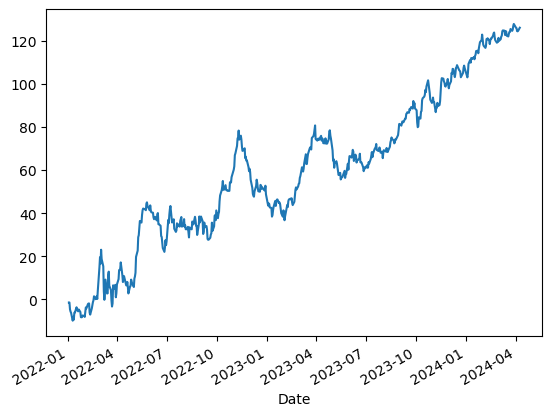

In [10]:
df_test['retorno_modelo'] = np.where(df_test['pred'] == 1, df_test['lag1']*100, -df_test['lag1']*100)
df_test['retorno_acumulado'] = df_test['retorno_modelo'].cumsum()
df_test['retorno_acumulado'].plot()

In [11]:
#salvar o modelo
import pickle
filename = 'reg_log.sav'
pickle.dump(lr_sm, open(filename, 'wb'))


lista = ['const',
 'curva1_cat','curva2_cat','curva3_cat','curva_final_cat',
 'COS_DIST3',
 'COS_DIST3_cat',
 'EUC_DIST3',
 'EUC_DIST3_cat']

df_test['const'] =1.0

model = pickle.load(open('reg_log.sav', 'rb'))
df_test['mod_reg'] = model.predict(df[lista])

df_test['mod_reg_bin'] = np.where(df_test['reg'] > 0, 1, 0)

C:\Users\camps pro\AppData\Local\Temp\ipykernel_6188\1605017300.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['const'] =1.0
C:\Users\camps pro\AppData\Local\Temp\ipykernel_6188\1605017300.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['mod_reg'] = model.predict(df[lista])
C:\Users\camps pro\AppData\Local\Temp\ipykernel_6188\1605017300.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [12]:
df_test['pred'].value_counts()

pred
1    370
0    214
Name: count, dtype: int64

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Definir as variáveis e o alvo
var = [ 'RSL5', 'RSL5q', 'RSL20', 'delta', 'gain', 'loss',
       'rsi', 'rsi_cat', 'filtro', 'media_movel', 'media_movel2',
       'tan200', 'ang200', 'ang_cat', 'sinal', 'rsi_sinal',
       'rsi_cat_sinal', 'desvio_padrao', 'media', 'ajuste_media',
       'max_diff', 'min_diff', 'R/S', 'hurst', 'hurst_sinal', 'std15',
       'MA', 'zscore', 'zscore_sinal', 'stochasticOscillator',
       'stochasticOscillator_sinal', 'bb_bollinger_avg', 'bb_lband',
       'bb_hband', 'sinal_bb', 'tan30', 'ang30', 'tan30_sinal',
       'tan30_cat', 'stochRSI', 'stochRSI_cat', 'stochRSI_sinal', 'Vol',
       'Date', 'WeekDay', 'WeeklyVol', 'RefPrice', 'Supply_Band_1d',
       'Demand_Band_1d', 'Supply_Band_2d', 'Demand_Band_2d', 'macd_9',
       'macd_26', 'disc_macs', 'dis_vol', 'dis_vol_cat', 'Return20',
       'sum_returns', 'return_cost', 'return_cost_cat', 'MA20',
       'STD_Returns', 'RSL', 'delta1', 'gain1', 'loss1', 'rsi1',
       'FRI_Returns', 'FRI_STD_Returns', 'FRI_RSL', 'FRI_rsi', 'COS_DIST',
       'COS_DIST_cat', 'COS_DIST2', 'COS_DIST2_cat', 'EUC_DIST',
       'EUC_DIST_cat', 'EUC_DIST2', 'EUC_DIST2_cat', 'curva_rsl',
       'curva_std', 'dis_rsl', 'dis_std', 'dis_euc_sinal',
       'dis_cos_sinal', 'RSL20_cat', 'Price_Lag', 'Price_Lag2', 'const',
       'beta0', 'beta1', 'beta2', 'reg', 'detrend_reg', 'MM20', 'index',
       'curva1_a', 'curva1_b', 'curva1_c', 'curva1_d', 'curva2_a',
       'curva2_b', 'curva2_c', 'curva2_d', 'curva3_a', 'curva3_b',
       'curva3_c', 'curva3_d', 'curva1', 'curva2', 'curva3',
       'curva_final', 'erro', 'curva1_otimizada', 'curva2_otimizada',
       'curva3_otimizada', 'curva_final_otimizada', 'curva_final_cat',
       'curva1_cat', 'curva2_cat', 'curva3_cat', 'cluster_curvas', 'FRI_curva_final',
       'FRI_curva1', 'FRI_curva2', 'FRI_curva3', 'FRI_hurst', 'COS_DIST3',
       'COS_DIST3_cat', 'EUC_DIST3', 'EUC_DIST3_cat', 'cluster_distance','mod_reg_bin','mod_reg']

alvo = 'Retorno4_bin'

# Intervalos de treinamento e teste
start_train = "2009-01-01"
end_train = "2022-12-31"
start_test = "2023-01-01"
end_test = "2024-04-19"

# Filtrar dados
df_filtrado = df.dropna()
df_train = df_filtrado[start_train:end_train]
df_test = df_filtrado[start_test:end_test]

# Inicializar lista para armazenar as variáveis com acurácia acima de 0.51
melhores_variaveis = []
lista = []
# Iterar sobre cada variável e treinar o modelo
for variavel in var:
    x_train = df_train[[variavel]]
    y_train = df_train[alvo]
    x_test = df_test[[variavel]]
    y_test = df_test[alvo]
    
    # Inicializar modelo de árvore de decisão
    mod_arvore = DecisionTreeClassifier(criterion="gini", max_depth=10, min_samples_leaf=5,
                                         min_samples_split=5, max_leaf_nodes=10)
    
    # Treinar o modelo
    mod_arvore.fit(x_train, y_train)
    
    # Prever os resultados
    y_pred = mod_arvore.predict(x_test)
    
    # Calcular a acurácia
    acuracia = accuracy_score(y_test, y_pred)
    
    # Verificar se a acurácia é maior que 0.51
    if acuracia > 0.54:
        # Armazenar a variável e acurácia correspondentes na lista
        melhores_variaveis.append((variavel, acuracia))
        lista.append(variavel)
# Armazenar as variáveis acima de 0.51 em um DataFrame
df_melhores_variaveis = pd.DataFrame(melhores_variaveis, columns=['Variável', 'Acurácia'])


In [ ]:
melhores_variaveis

[('max_diff', 0.5462686567164179),
 ('WeekDay', 0.5432835820895522),
 ('WeeklyVol', 0.5402985074626866),
 ('FRI_STD_Returns', 0.5402985074626866),
 ('EUC_DIST', 0.5432835820895522),
 ('curva_rsl', 0.5432835820895522),
 ('curva_std', 0.5432835820895522),
 ('curva1_cat', 0.5582089552238806),
 ('FRI_curva1', 0.5582089552238806),
 ('COS_DIST3', 0.5701492537313433),
 ('COS_DIST3_cat', 0.5462686567164179)]